## Data preparation

__TO-DO__  
- Combine the __orientation determination code__ in the orientation adjustment part

### 1. Load Dicom data

In [45]:
import os
import re
import time
import random
import cv2
import numpy as np
import pandas as pd
import glob
import pydicom
from pydicom import dcmread
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

%matplotlib inline
import matplotlib.pyplot as plt

from skimage.transform import resize

In [46]:
data_path = '/mnt/24CC5B14CC5ADF9A/BraTs_2021/BraTs_2021_Data'
save_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_Prep_90'

# MRI Type names used in Task 1 Data
mri_types_lowercase = ['flair','t1','t1ce','t2']

# MRI Type names used in Task 2 Data
mri_types_capital = ['FLAIR','T1w','T1wCE','T2w']

In [47]:
def load_patient_IDs(path,split='train'):
    ids_list=[]
    for item in os.listdir(f'{path}/{split}'):
        index = re.fullmatch(r'[^0-9]|[0-9]+',item)
        if  index is None:
            pass
        else:
            ids_list.append(index[0])
    # Remove error patients ids on train set
    if split == 'train':
        error_ids = ['00109','00123','00709']
        for item in error_ids:
            ids_list.remove(item)
    print(f'Loading patient ids on {split} set.\nTotal {len(ids_list)} patient IDs are read.')
    return ids_list

full_ids = load_patient_IDs(data_path)

Loading patient ids on train set.
Total 582 patient IDs are read.


In [48]:
def pad_or_crop_image(image,target_size):
    """
    Used to resized the image to the target size with crop or pad
    """
    def get_left_right_idx_should_pad(target_size, dim):
        if dim >= target_size:
            return [False]
        elif dim < target_size:
            pad_extent = target_size - dim
            left = pad_extent//2
            right = pad_extent - left
            return True, left, right

    def get_crop_slice(target_size, dim):
        if dim > target_size:
            crop_extent = dim - target_size
            left = crop_extent//2
            right = crop_extent - left
            return slice(left, dim - right)
        elif dim <= target_size:
            return slice(0, dim)
    y, x = image.shape
    y_slice, x_slice = [get_crop_slice(target, dim) for target, dim in zip(target_size, (y, x))]
    image = image[y_slice, x_slice]
    todos = [get_left_right_idx_should_pad(size, dim) for size, dim in zip(target_size, [y, x])]
    padlist = []  # channel dim
    for to_pad in todos:
        if to_pad[0]:
            padlist.append((to_pad[1], to_pad[2]))
        else:
            padlist.append((0,0))
    image = np.pad(image, padlist)
    
    return image

In [49]:
def pad_or_crop_image_3d(image,target_size=(256, 256, 256)):
    def get_left_right_idx_should_pad(target_size, dim):
        if dim >= target_size:
            return [False]
        elif dim < target_size:
            pad_extent = target_size - dim
            left = pad_extent//2
            right = pad_extent - left
            return True, left, right


    def get_crop_slice(target_size, dim):
        if dim > target_size:
            crop_extent = dim - target_size
            left = crop_extent//2
            right = crop_extent - left
            return slice(left, dim - right)
        elif dim <= target_size:
            return slice(0, dim)
        
    z, y, x = image.shape
    z_slice, y_slice, x_slice = [get_crop_slice(target, dim) for target, dim in zip(target_size, (z, y, x))]
    image = image[z_slice, y_slice, x_slice]
    todos = [get_left_right_idx_should_pad(size, dim) for size, dim in zip(target_size, [z, y, x])]
    padlist = []  # channel dim
    for to_pad in todos:
        if to_pad[0]:
            padlist.append((to_pad[1], to_pad[2]))
        else:
            padlist.append((0, 0))
    image = np.pad(image, padlist)
    return image

In [50]:
def load_3D_image(path, scan_id,fixed_size = 240,mri_type="FLAIR", split="train"):
    """
    Load 2D dicom images and stack them into a 3D volume
    """
    # Obtain dicom header information
    full_id = str(scan_id).zfill(5)
    files = sorted(glob.glob(f"{data_path}/{split}/{full_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    files_header = [pydicom.dcmread(f) for f in files]
    
    
    # Re-arrange the slice based on slice location
    slices = []
    for h in files_header:
        if hasattr(h, 'SliceLocation'):
            slices.append(h)
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    EXCEPTION: No slice location attribute
    """
    if len(slices)==0:
        print(f'{scan_id} has no slice location attribute')
        slices = files_header
        length = len(slices)
        ps = slices[0].PixelSpacing
        avg_dist = slices[0].SliceThickness
        max_edge = max(slices[0].pixel_array.shape[0],slices[0].pixel_array.shape[1])
        img_shape = (max_edge,max_edge,length)
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices):
            img3d[:, :, i] = pad_or_crop_image(s.pixel_array,(max_edge,max_edge))
        resize_shape = (int(max_edge*ps[0]),int(max_edge*ps[1]),int(length*avg_dist))
        resize_3d = resize(img3d,resize_shape,anti_aliasing=False)
        
        re_length = resize_3d.shape[2]
        
        fixed_shape = (resize_3d.shape[0],resize_3d.shape[0],resize_3d.shape[0])
        fixed_3d = np.zeros(fixed_shape)
        
        #Padding
        start = (resize_3d.shape[0]-re_length)//2
        end = start+re_length
        for i in range(start,end):
            fixed_3d[:,:,i] = resize_3d[:,:,i-start]
            
        return pad_or_crop_image_3d(fixed_3d)
    
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        
        
    length = len(slices)
    # Fill 3D array with the images from the dicom files based on related variables
    # Target 3D Volume space: 1*1*1
    # Target Size = (coordinate_1*pixelspacing_1,coordinate_2*pixelspacing_2,coordinate_3*thickness)
    ps = slices[0].PixelSpacing
    avg_dist = abs((slices[0].SliceLocation-slices[-1].SliceLocation)/length)
    avg_dist = round(avg_dist,1)
    
    if slices[0].pixel_array.shape[0]!=slices[0].pixel_array.shape[1]:
        # When column not equal to row, pad the image to obtain a square size
        max_edge = max(slices[0].pixel_array.shape[0],slices[0].pixel_array.shape[1])
        img_shape = (max_edge,max_edge,length)
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices):
            img3d[:, :, i] = pad_or_crop_image(s.pixel_array,(max_edge,max_edge))
        resize_shape = (int(max_edge*ps[0]),int(max_edge*ps[1]),int(length*avg_dist))
        resize_3d = resize(img3d,resize_shape)
        
    else:
        img_shape = (slices[0].pixel_array.shape[0],slices[0].pixel_array.shape[1],length)
        img3d = np.zeros(img_shape)
        for i, s in enumerate(slices):
            img3d[:, :, i] = s.pixel_array
        resize_shape = (int(s.pixel_array.shape[0]*ps[0]),int(s.pixel_array.shape[1]*ps[0]),int(length*avg_dist))
        resize_3d = resize(img3d,resize_shape)
    
    #Re-arrange the 3D array to a fixed cube
    if resize_3d.shape[2]<resize_3d.shape[0]:
        re_length = resize_3d.shape[2]
        
        fixed_shape = (resize_3d.shape[0],resize_3d.shape[0],resize_3d.shape[0])
        fixed_3d = np.zeros(fixed_shape)
        
        #Padding
        start = (resize_3d.shape[0]-re_length)//2
        end = start+re_length
        for i in range(start,end):
            fixed_3d[:,:,i] = resize_3d[:,:,i-start]
            
    elif resize_3d.shape[2]>resize_3d.shape[0]:
        re_length = resize_3d.shape[0]
        
        fixed_shape = (resize_3d.shape[0],resize_3d.shape[0],resize_3d.shape[0])
        fixed_3d = np.zeros(fixed_shape)
        
        #Crop
        start = (resize_3d.shape[2]-re_length)//2
        end = start+re_length
        for i in range(start,end):
            fixed_3d[:,:,i-start] = resize_3d[:,:,i]
    else:
        fixed_3d = resize_3d

    return pad_or_crop_image_3d(fixed_3d,(fixed_size,fixed_size,fixed_size))

Patient example from dicom images

PatientID: 00602 
Modality: T2w
Shape: (240, 240, 240)


Text(0.5, 1.0, 'T1w')

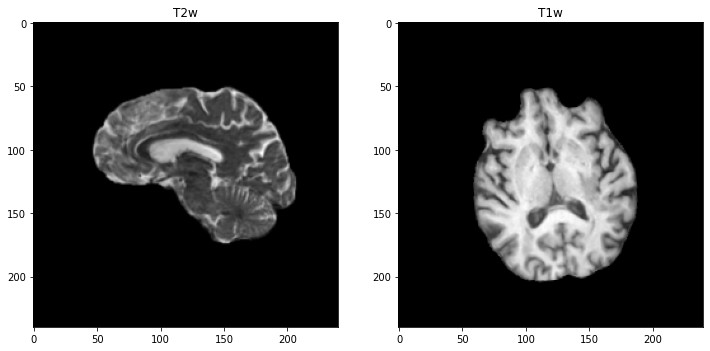

In [51]:
# test_ID = random.choice(full_ids)
# test_mri_type =random.choice(mri_types_capital)
test_ID = '00602'
test_mri_type = 'T2w'
print(f'PatientID: {test_ID} \nModality: {test_mri_type}')

test_data = load_3D_image(data_path,test_ID,240,test_mri_type)
target_data = load_3D_image(data_path,test_ID,240,'T1w')
print(f'Shape: {test_data.shape}')

# Dispaly the central image of brain
fig, axes = plt.subplots(1,2, figsize=(12, 12))

fig.subplots_adjust(top=0.95)

axes[0].imshow(test_data[:,:,test_data.shape[2]//2],cmap = 'gray')
axes[0].set_title(f'{test_mri_type}', fontsize=12)
axes[0].set_aspect(1)

axes[1].imshow(target_data[:,:,target_data.shape[2]//2],cmap = 'gray')
axes[1].set_title('T1w', fontsize=12)

### 2.Adjust Orientation

In [52]:
def adjust_orientation(data,orientation):
    size = data.shape[0]
    adjusted = np.zeros((size,size,size))
    
    if orientation == 0:
        for i in range(size):
            transposed = data[size-i-1,:,:].T
            rotated = ndimage.rotate(transposed, -90)
            adjusted[:,:,i] = rotated
            
    elif orientation == 1:
        for i in range(size):
            transposed = data[size-i-1,:,:].T
            rotated = ndimage.rotate(transposed, 180)
            fliped = cv2.flip(rotated,1,dst=None)
            adjusted[:,:,i] = fliped
                
    elif orientation == 2:
            return data
    
    return adjusted

In [53]:
df_ori = pd.read_csv('Brats2021_Orientation.csv')
df_ori['BraTS21ID'] = df_ori['BraTS21ID'].astype('string')

for i in range(len(df_ori['BraTS21ID'].values)):
    index = df_ori['BraTS21ID'][i]
    df_ori['BraTS21ID'][i] = index.zfill(5)
    
df_ori.head()

,BraTS21ID,FLAIR,T1w,T1wCE,T2w
0,00000,1,2,1,0
1,00002,0,2,1,0
2,00003,0,2,1,0
3,00005,1,2,1,0
4,00006,2,2,1,0


Patient example of Orientation Adjustment

Text(0.5, 1.0, 'T1w')

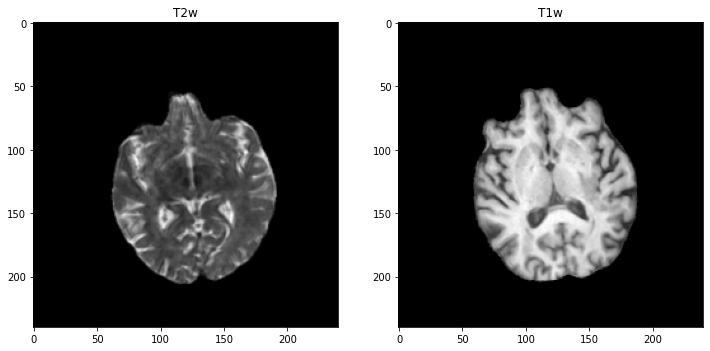

In [54]:
test_orientation = df_ori[df_ori['BraTS21ID'] == test_ID][f'{test_mri_type}'].values
test_orientation_adjustment = adjust_orientation(test_data,test_orientation)

# Dispaly the central image of adjusted brain
fig, axes = plt.subplots(1,2, figsize=(12, 12))

fig.subplots_adjust(top=0.95)

axes[0].imshow(test_orientation_adjustment[:,:,test_orientation_adjustment.shape[2]//2],cmap = 'gray')
axes[0].set_title(f'{test_mri_type}', fontsize=12)
axes[0].set_aspect(1)

axes[1].imshow(target_data[:,:,target_data.shape[2]//2],cmap = 'gray')
axes[1].set_title('T1w', fontsize=12)

### 3. Registration

In [55]:
def registration(fixed_image_array,moving_image_array):
    fixed_image =  sitk.GetImageFromArray(fixed_image_array)
    moving_image = sitk.GetImageFromArray(moving_image_array)
    
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=0.5, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat64), 
                                                   sitk.Cast(moving_image, sitk.sitkFloat64))
    
    # print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    resampled_img_array = sitk.GetArrayFromImage(moving_resampled)
    
    return resampled_img_array

In [56]:
fixed_image_array = target_data
moving_image_array = test_orientation_adjustment
resampled_img_array = registration(fixed_image_array,moving_image_array)

Patient example of Registration

Text(0.5, 1.0, 'Fixed-T2w')

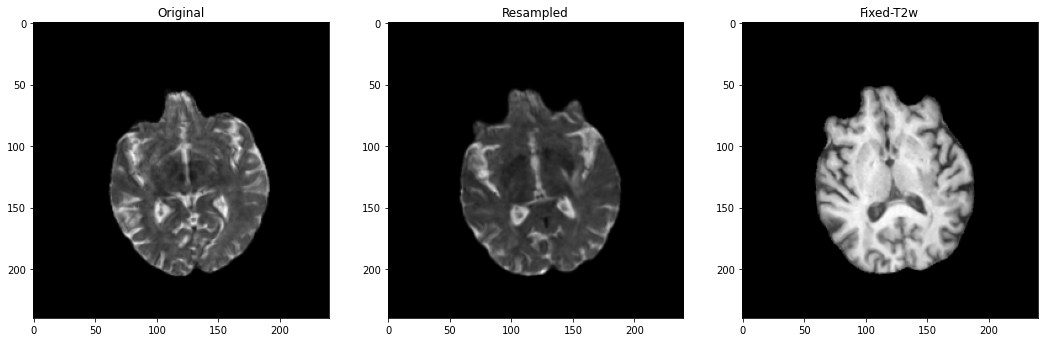

In [57]:
# Dispaly the central image of adjusted brain
fig, axes = plt.subplots(1,3, figsize=(18, 12))

fig.subplots_adjust(top=0.95)
axes[0].imshow(moving_image_array[:,:,moving_image_array.shape[2]//2],cmap = 'gray')
axes[0].set_title('Original', fontsize=12)

axes[1].imshow(resampled_img_array[:,:,resampled_img_array.shape[2]//2],cmap = 'gray')
axes[1].set_title('Resampled', fontsize=12)


axes[2].imshow(fixed_image_array[:,:,fixed_image_array.shape[2]//2],cmap = 'gray')
axes[2].set_title('Fixed-T2w', fontsize=12)

### 4. Rescale

In [58]:
def rescale_3d(data,image_size,scale_size):
    """ 
    Rescale data to a assigned size
    
    """
    fixed_data = resize(data,(scale_size,scale_size,scale_size),anti_aliasing=True)
    
        
    return fixed_data

### 5. Complete data preparation

In [59]:
# MRI Type names used in Task 1 Data
mri_types_lowercase = ['flair','t1','t1ce','t2']

# MRI Type names used in Task 2 Data
mri_types_capital = ['FLAIR','T1w','T1wCE','T2w']

def data_preparation(data_path,save_path,full_id_list,image_size=240,scale_size=155):
    start = time.time()
    for num, scan_id in enumerate(full_id_list,start = 1):
        # Prepare T2w first for the following registration
        orientation_type = df_ori[df_ori['BraTS21ID'] == scan_id]['T2w'].values
            
        raw_data = load_3D_image(data_path,scan_id,image_size,'T2w')
        adjusted_data = adjust_orientation(raw_data,orientation_type)
        
        fixed_t2w_data = adjusted_data
            
        # Perform Re-scale
        rescaled_data = rescale_3d(adjusted_data,image_size,scale_size)
        
        # Save data
        save_folder = f'BraTS2021_{scan_id}'
        new_save_path = os.path.join(save_path, save_folder)
        if save_folder not in os.listdir(save_path):
                os.mkdir(new_save_path)
            
        img = nib.Nifti1Image(rescaled_data, np.eye(4))  # Save axis for data (just identity)

        img.header.get_xyzt_units()
        img.to_filename(os.path.join(new_save_path,f'BraTS2021_{scan_id}_t2.nii.gz'))  # Save as NiBabel file
        
        for count, mri_type in enumerate(mri_types_capital[:3]):
            # Load raw data and perform adjustment
            orientation_type = df_ori[df_ori['BraTS21ID'] == scan_id][f'{mri_type}'].values
            
            raw_data = load_3D_image(data_path,scan_id,image_size,mri_type)
            adjusted_data = adjust_orientation(raw_data,orientation_type)
            
            # Perform Registration
            resampled_data = registration(fixed_t2w_data,adjusted_data)
            
            # Perform Re-scale
            rescaled_data = rescale_3d(resampled_data,image_size,scale_size)
            
            # Save data
            img = nib.Nifti1Image(rescaled_data, np.eye(4))  # Save axis for data (just identity)

            img.header.get_xyzt_units()
            img.to_filename(os.path.join(new_save_path,f'BraTS2021_{scan_id}_{mri_types_lowercase[count]}.nii.gz'))  # Save as NiBabel file
            
        print(f'{scan_id}: Done! Average Time:{(time.time()-start)/num:.2f}s',end='\r')
            
    print(f'\nData Preraration completed in {int(time.time()-start)}s')

In [67]:
data_preparation(data_path,save_path,full_ids[5:],scale_size=90)

00157 has no slice location attribute
00170 has no slice location attribute
00186 has no slice location attribute
00353 has no slice location attribute
00367 has no slice location attribute
00414 has no slice location attribute
00561 has no slice location attribute
00563 has no slice location attribute
00564 has no slice location attribute
00565 has no slice location attribute
00756 has no slice location attribute
00834 has no slice location attribute
00834 has no slice location attribute
00839 has no slice location attribute
01010: Done! Average Time:17.54s
Data Preraration completed in 10120s


00273


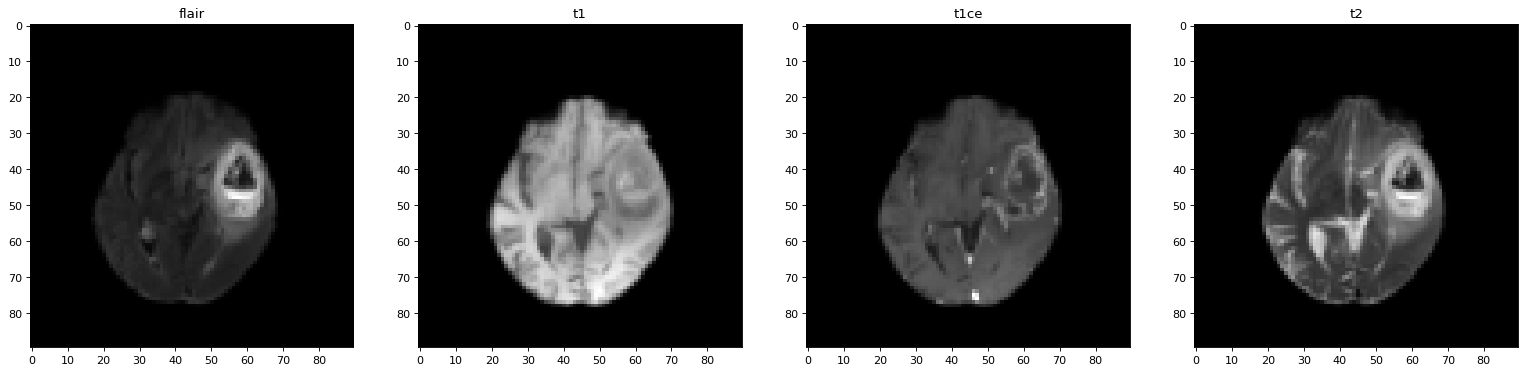

In [68]:
scan_id = full_ids[200]
print(scan_id)

plt.rcParams['figure.dpi'] = 80

fig, axes = plt.subplots(1,4, figsize=(24, 6))

for i in range(4):
    display_data = nib.load(f'{save_path}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_{mri_types_lowercase[i]}.nii.gz').get_fdata().astype('float')
    # print(display_data.shape)
    axes[i].imshow(display_data[:,:,45],cmap = 'gray')
    axes[i].set_title(f'{mri_types_lowercase[i]}', fontsize=12)

In [24]:
seg_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/T4E_MICCAI_BrainTumor-master/data/task1_data'
img = nib.load(f'{seg_data_path}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_t2.nii.gz')
seg_data = img.get_fdata().astype('float')

prepared_data = nib.load(f'{save_path}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_t2.nii.gz').get_fdata().astype('float')

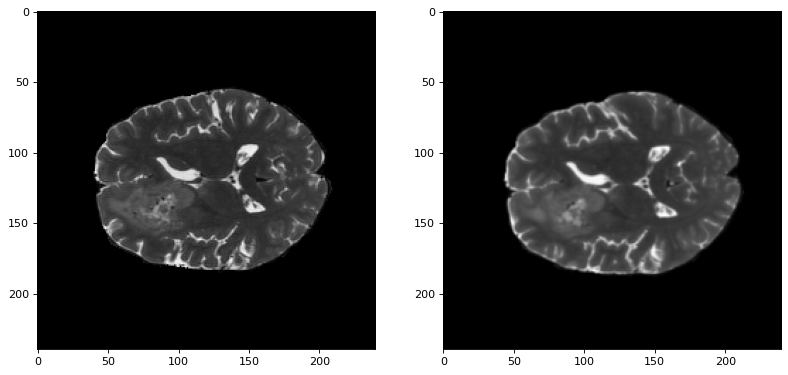

In [37]:
plt.rcParams['figure.dpi'] = 80

fig, axes = plt.subplots(1,2, figsize=(12, 6))


axes[0].imshow(seg_data[:,:,80],cmap = 'gray')
axes[1].imshow(prepared_data[:,:,91],cmap = 'gray')